In [1]:
import scipy.io
import sys
import csv
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
filepath = './physionet.org/files/ecg-arrhythmia/1.0.0/WFDBRecords'

In [3]:
waveform = scipy.io.loadmat(filepath+'/07/070/JS06344'+'.mat')['val']

In [4]:
waveform = scipy.io.loadmat('E09000'+'.mat')['val']

In [5]:
waveform

array([[-39, -39, -39, ..., -24, -29, -34],
       [-39, -39, -39, ...,  14,   9,   4],
       [  0,   0,   0, ...,  39,  39,  39],
       ...,
       [ 29,  29,  29, ..., -68, -68, -68],
       [ 97,  97,  97, ...,  78,  78,  78],
       [-19, -19, -19, ...,  19,  19,  19]], dtype=int16)

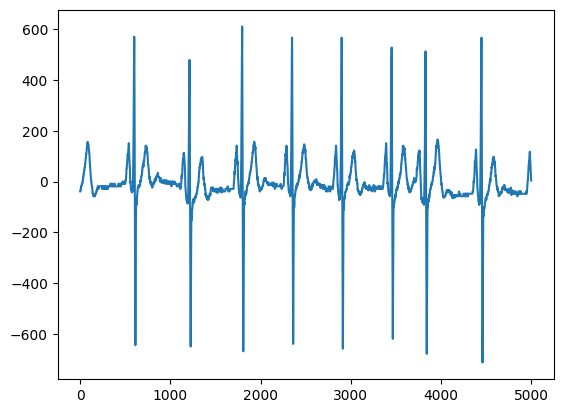

In [10]:
plt.plot(waveform.transpose()[:,1])

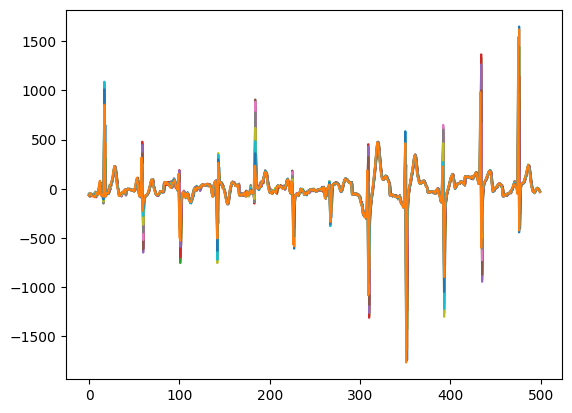

In [7]:
def plotwave(x, n=1000):
    x = x[0,1000:1500]
    plt.plot(x.reshape(x.shape[1], x.shape[0]))

plotwave(waveform)